In [ ]:
import os
import sys

In [ ]:
!pip install --quiet git+https://github.com/google-research/weatherbench2.git
!pip install --quiet Cartopy
if os.path.isdir('DL4WeatherAndClimate'):
  !rm -rf DL4WeatherAndClimate
!git clone --depth 1 --branch main https://github.com/max-ksoll/DL4WeatherAndClimate.git
!pip install -r /content/DL4WeatherAndClimate/requirements.txt
sys.path.append('/content/DL4WeatherAndClimate')

In [ ]:
import apache_beam
import weatherbench2
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import zarr

from tqdm import tqdm
from google.colab import auth, drive
from weatherbench2 import config
from weatherbench2.metrics import MSE, ACC
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
from torch.utils.data import DataLoader
from DL4WeatherAndClimate.src.era5_dataset import ERA5Dataset, TimeMode
from DL4WeatherAndClimate.src.fuxi_ligthning import FuXi

In [ ]:
auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
forecast_path = '/content/preds.zarr'
obs_path = 'gs://gcp-public-data-arco-era5/ar/1959-2022-6h-240x121_equiangular_with_poles_conservative.zarr'
climatology_path = 'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2017_6h_240x121_equiangular_with_poles_conservative.zarr'

In [ ]:
bs = 1
autoregression_steps = 10*4
timesteps_cnt = 2
levels_cnt = 2
vars_cnt = 5
lats_cnt = 121
lons_cnt = 240
start_time = "2019-12-31T12:00:00"
end_time = "2020-12-31T18:00:00"
model_path = "/content/DL4WeatherAndClimate/tracked_models/model.ckpt"
model = FuXi.load_from_checkpoint(model_path)
model: FuXi
model.set_autoregression_steps(autoregression_steps)
dataset = ERA5Dataset(
    obs_path,
    TimeMode.BETWEEN,
    start_time=start_time,
    end_time=end_time,
    max_autoregression_steps=autoregression_steps,
    zarr_col_names='gcloud',
    use_xarray=True,
    ds=xr.open_dataset(obs_path)
)
dl = DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
store = zarr.DirectoryStore(forecast_path)
root = zarr.group(store=store, overwrite=True)

latitude = root.create_dataset('latitude', shape=(0,), chunks=(lats_cnt,), dtype=np.float64, fill_value=-99999)
levels = root.create_dataset('level', shape=(0,), chunks=(levels_cnt,), dtype=np.int32, fill_value=-99)
longitude = root.create_dataset('longitude', shape=(0,), chunks=(lons_cnt,), dtype=np.float64, fill_value=-99999)
pred_timedelta = root.create_dataset('prediction_timedelta', shape=(0,), chunks=(autoregression_steps,),
                                     dtype='timedelta64[ns]')

time = root.create_dataset('time', shape=(0,), chunks=(timesteps_cnt,), dtype='datetime64[ns]', fill_value=-99999)

temp = root.create_dataset('temperature', shape=(0, autoregression_steps, levels_cnt, lats_cnt, lons_cnt),
                           dtype=np.float64,
                           chunks=(16, autoregression_steps, levels_cnt, lats_cnt, lons_cnt), fill_value=-99999)
temp.attrs['_ARRAY_DIMENSIONS'] = ['time', 'prediction_timedelta', 'level', 'latitude', 'longitude']
humid = root.create_dataset('specific_humidity', shape=(0, autoregression_steps, levels_cnt, lats_cnt, lons_cnt),
                            dtype=np.float64,
                            chunks=(16, autoregression_steps, levels_cnt, lats_cnt, lons_cnt), fill_value=-99999)
humid.attrs['_ARRAY_DIMENSIONS'] = ['time', 'prediction_timedelta', 'level', 'latitude', 'longitude']
uwind = root.create_dataset('u_component_of_wind', shape=(0, autoregression_steps, levels_cnt, lats_cnt, lons_cnt),
                            dtype=np.float64,
                            chunks=(16, autoregression_steps, levels_cnt, lats_cnt, lons_cnt), fill_value=-99999)
uwind.attrs['_ARRAY_DIMENSIONS'] = ['time', 'prediction_timedelta', 'level', 'latitude', 'longitude']
vwind = root.create_dataset('v_component_of_wind', shape=(0, autoregression_steps, levels_cnt, lats_cnt, lons_cnt),
                            dtype=np.float64,
                            chunks=(16, autoregression_steps, levels_cnt, lats_cnt, lons_cnt), fill_value=-99999)
vwind.attrs['_ARRAY_DIMENSIONS'] = ['time', 'prediction_timedelta', 'level', 'latitude', 'longitude']
geo = root.create_dataset('geopotential', shape=(0, autoregression_steps, levels_cnt, lats_cnt, lons_cnt),
                          dtype=np.float64,
                          chunks=(16, autoregression_steps, levels_cnt, lats_cnt, lons_cnt), fill_value=-99999)
geo.attrs['_ARRAY_DIMENSIONS'] = ['time', 'prediction_timedelta', 'level', 'latitude', 'longitude']

latitude.append(np.linspace(-90, 90, lats_cnt))
latitude.attrs['_ARRAY_DIMENSIONS'] = ['latitude']

levels.append([500, 850])
levels.attrs['_ARRAY_DIMENSIONS'] = ['level']

longitude.append(np.linspace(0, 358.5, lons_cnt))
longitude.attrs['_ARRAY_DIMENSIONS'] = ['longitude']

timedelta = [np.timedelta64(6 * i, 'h') for i in range(autoregression_steps)]
pred_timedelta.append(np.array(timedelta))
pred_timedelta.attrs['_ARRAY_DIMENSIONS'] = ['prediction_timedelta']

times = [np.datetime64(start_time) + 2* timedelta[1] + i * timedelta[1] for i in range(timesteps_cnt)]
time.append(times)
time.attrs['_ARRAY_DIMENSIONS'] = ['time']

In [ ]:
mins = torch.Tensor([193.48901, -3.3835982e-05, -65.45247, -96.98215, -6838.8906])
maxs = torch.Tensor([324.80637, 0.029175894, 113.785934, 89.834595, 109541.625])
max_minus_min = maxs - mins
mins = mins[:, None, None]
max_minus_min = max_minus_min[:, None, None]

for idx, batch in tqdm(enumerate(dl)):
    if idx > timesteps_cnt-1:
        break
    #x,y = batch
    #batch = x.cuda(), y.cuda()
    out = model.forward(batch)[0, :, :, :, :]
    preds = torch.reshape(out, (autoregression_steps, vars_cnt, out.shape[1] // vars_cnt, lats_cnt, lons_cnt))
    preds = (preds*max_minus_min+mins).numpy()
    temp.append(preds[None, :, 2:4, 0, :, :], axis=0)
    humid.append(preds[None, :, 2:4, 1, :, :], axis=0)
    uwind.append(preds[None, :, 2:4, 2, :, :], axis=0)
    vwind.append(preds[None, :, 2:4, 3, :, :], axis=0)
    geo.append(preds[None, :, 2:4, 4, :, :], axis=0)

zarr.consolidate_metadata(store)

2it [04:38, 139.48s/it]


<zarr.hierarchy.Group '/'>

In [ ]:
climatology = xr.open_zarr(climatology_path)
paths = config.Paths(
    forecast=forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)
selection = config.Selection(
    variables=[
        'temperature',
        'specific_humidity',
        'u_component_of_wind',
        'v_component_of_wind',
        'geopotential'
    ],
    levels=[850],
    time_slice=slice('2020-01-01', '2020-01-01'),
)
data_config = config.Data(selection=selection, paths=paths)

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(),
          'acc': ACC(climatology=climatology)
      },
  )
}

regions = {
    'global': SliceRegion(),
    #'asia': SliceRegion(lat_slice=slice(10, 80), lon_slice=slice(-170+180, 25+180)),
    #'africa': SliceRegion(lat_slice=slice(-35, 37), lon_slice=slice(-17+180, 17+180)),
    #'europe': SliceRegion(lat_slice=slice(35, 73), lon_slice=slice(-25+180, 65+180)),
    #'north_america': SliceRegion(lat_slice=slice(7, 84), lon_slice=slice(-180+180, -20+180)),
    #'south_america': SliceRegion(lat_slice=slice(-55, 12), lon_slice=slice(-81+180, -35+180)),
    #'australia': SliceRegion(lat_slice=slice(-40, -10), lon_slice=slice(280, 165+180)),
}

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(),
          'acc': ACC(climatology=climatology)
      },
      regions=regions
  )
}

In [ ]:
evaluate_in_memory(data_config, eval_configs)

In [ ]:
results = xr.open_dataset('./deterministic.nc')

In [ ]:
x = [1 + 0.25*i for i in range(40)]
x_plot = [1,2,3,4,5,6,7,8,9,10]

fig = plt.figure()
ax = plt.subplot(111)

for variable in ["temperature", "specific_humidity", "u_component_of_wind", "v_component_of_wind", "geopotential"]:
    y = np.array(results[variable].sel(metric='acc', region='global')).flatten()
    #print(y)
    ax.plot(x,y, label=variable)

plt.xticks(x_plot)
plt.xlabel("Day")
plt.ylabel("ACC")
plt.title(f"ACC for 2020-01-01 to 2020-01-10")

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.15,box.width, box.height * 0.85])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)

plt.savefig(f"/content/drive/MyDrive/MLEarth/acc.png")
plt.show()
plt.close()

In [ ]:
x = [1 + 0.25*i for i in range(40)]
x_plot = [1,2,3,4,5,6,7,8,9,10]

for variable in ["temperature", "specific_humidity", "u_component_of_wind", "v_component_of_wind"]:
    y = np.sqrt(np.array(results[variable].sel(metric='mse', region='global')).flatten())
    plt.plot(x,y, label=variable)

    plt.xticks(x_plot)
    plt.xlabel("Day")
    plt.ylabel("RMSE")
    plt.title(f"RMSE {variable} for 2020-01-01 to 2020-01-10")
    plt.savefig(f"/content/drive/MyDrive/MLEarth/rmse_{variable}.png")
    plt.show()
    plt.close()

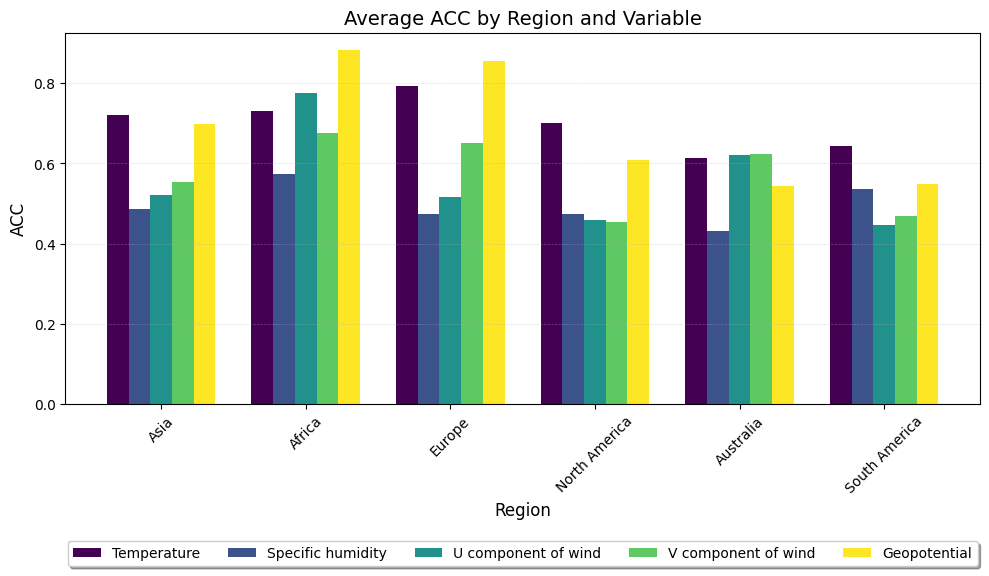

In [ ]:
regions = ["asia", "africa", "europe", "north_america", "australia", "south_america"]
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(results.keys())))

x_axis = np.arange(len(regions))
bar_width = 0.15  # Width of the bars
offset = bar_width * (len(results) - 1) / 2  # Offset to center the bars around the x ticks

# Create a bar plot
plt.figure(figsize=(10, 6))  # Making the plot larger than the default
for idx, variable in enumerate(results):
    accs = [np.mean(results[variable].sel(region=region, metric='acc')) for region in regions]  # Adjust the data extraction as per your data structure
    plt.bar(x_axis - offset + bar_width * idx, accs, width=bar_width, label=variable.replace('_', ' ').capitalize(), color=colors[idx])

# Enhancing the plot
plt.xticks(x_axis, [region.replace('_', ' ').title() for region in regions], rotation=45)  # Rotate x labels for better readability
plt.xlabel('Region', fontsize=12)  # Larger font size for axis label
plt.ylabel('ACC', fontsize=12)  # Larger font size for axis label
plt.title('Average ACC by Region and Variable', fontsize=14)  # Adding a title

# Adding grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y', alpha=0.4)

# Adjusting plot layout to make space for the legend below the plot
plt.tight_layout(rect=[0, 0.1, 1, 1])

# Adding legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), fancybox=True, shadow=True, ncol=len(results))

# Display the improved plot
plt.savefig(f"/content/drive/MyDrive/MLEarth/barplot_acc.png")
plt.show()

In [ ]:
extreme_values = dict()

ds_obs = xr.open_dataset(obs_path)
ds_forecast = xr.open_dataset(forecast_path)
ds_forecast['time'] = ds_forecast['time'] + np.timedelta64(6*39, 'h')
common_times = np.intersect1d(ds_obs['time'], ds_forecast['time'])
ds_obs = ds_obs.sel(time=common_times)
new_lat = np.linspace(-90, 90, 180)  # 180 neue Breitengrade
new_lon = np.linspace(0, 360, 360)  # 360 neue Längengrade
for variable in ["temperature", "specific_humidity", "u_component_of_wind", "v_component_of_wind", "geopotential"]:
  # Interpolation der Beobachtungsdaten auf das neue Koordinatensystem
  obs = ds_obs[variable].sel(level=850)
  obs = obs.interp(latitude=new_lat, longitude=new_lon, method='quadratic', kwargs={"fill_value": "extrapolate"})
  # Interpolation der Vorhersagedaten auf das neue Koordinatensystem
  forecast = ds_forecast[variable].isel(prediction_timedelta=39, level=1)
  forecast = forecast.interp(latitude=new_lat, longitude=new_lon, method='linear', kwargs={"fill_value": "extrapolate"})
  # Differenz und durchschnittliche Differenz berechnen
  difference = obs - forecast
  average_difference = difference.mean(dim='time').transpose('latitude', 'longitude')
  average_difference[:2]=0
  average_difference[-2:]=0
  extreme_values[variable] = np.array(average_difference).max().item()
  print(f"{variable} {extreme_values[variable]}")

/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


temperature 14.601201108136905
specific_humidity 0.008576997574097994
u_component_of_wind 21.040651040977806
v_component_of_wind 32.34058443756905
geopotential 1667.0990396236084


In [ ]:
def get_units(variable):
    units = {
        'temperature': 'K',  # Kelvin
        'specific_humidity': 'kg/kg',  # Kilogramm pro Kilogramm
        'u_component_of_wind': 'm/s',  # Meter pro Sekunde
        'v_component_of_wind': 'm/s',  # Meter pro Sekunde
        'geopotential': 'm²/s²'  # Quadratmeter pro Quadratsekunde
    }
    if variable in units:
        return units.get(variable, None)

def getExtrem(variable):
    return extreme_values.get(variable, None)

In [ ]:
def plot_average_difference_over_time(obs_path, forecast_path, variable, prediction_timedelta):
    # Daten für die Beobachtung laden und vorbereiten
    ds_obs = xr.open_dataset(obs_path)
    ds_forecast = xr.open_dataset(forecast_path)

    new_lat = np.linspace(-90, 90, 180)  # 180 neue Breitengrade
    new_lon = np.linspace(0, 360, 360)  # 360 neue Längengrade

    # Daten für die Vorhersage laden und vorbereiten

    ds_forecast.coords['longitude'] = (ds_forecast.coords['longitude'])
    ds_forecast['time'] = ds_forecast['time'] + np.timedelta64(6*prediction_timedelta, 'h')

    common_times = np.intersect1d(ds_obs['time'], ds_forecast['time'])
    ds_obs = ds_obs.sel(time=common_times)


    # Interpolation der Beobachtungsdaten auf das neue Koordinatensystem
    obs = ds_obs[variable].sel(level=850)
    obs = obs.interp(latitude=new_lat, longitude=new_lon, method='quadratic', kwargs={"fill_value": "extrapolate"})

    # Interpolation der Vorhersagedaten auf das neue Koordinatensystem
    forecast = ds_forecast[variable].isel(prediction_timedelta=prediction_timedelta, level=1)
    forecast = forecast.interp(latitude=new_lat, longitude=new_lon, method='linear', kwargs={"fill_value": "extrapolate"})

    # Differenz und durchschnittliche Differenz berechnen
    difference = obs - forecast

    average_difference = difference.mean(dim='time').transpose('latitude', 'longitude')
    average_difference[0]=0
    average_difference[1]=0
    average_difference[179]=0
    average_difference[178]=0


    # Karte plotten
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.Robinson()})
    ax.coastlines()

    # Landflächen grau darstellen, wenn unter 850 hPa

    # Daten plotten. ,vmin=-getExtrem(variable), vmax=getExtrem(variable)
    im = average_difference.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='bwr',vmin=-getExtrem(variable), vmax=getExtrem(variable))
    plt.colorbar(im, ax=ax, orientation='horizontal', shrink=0.5).set_label(f'bias [{get_units(variable)}]')
    ax.set_title(f'')
    os.makedirs(f'/content/drive/MyDrive/MLEarth/{variable}', exist_ok=True)
    plt.savefig(f'/content/drive/MyDrive/MLEarth/{variable}/FUXI{variable.title()}-{prediction_timedelta/4+0.25}days.png')
    plt.close()
    #plt.show()
    print(f'finished: /content/drive/MyDrive/MLEarth/{variable}/FUXI{variable.title()}-{prediction_timedelta/4+0.25}days.png')

plot_average_difference_over_time(obs_path,forecast_path, 'specific_humidity', 4*1 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'specific_humidity', 4*3 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'specific_humidity', 4*7 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'specific_humidity', 4*10 - 1)

plot_average_difference_over_time(obs_path,forecast_path, 'temperature', 4*1 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'temperature', 4*3 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'temperature', 4*7 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'temperature', 4*10 - 1)

plot_average_difference_over_time(obs_path,forecast_path, 'u_component_of_wind', 4*1 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'u_component_of_wind', 4*3 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'u_component_of_wind', 4*7 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'u_component_of_wind', 4*10 - 1)

plot_average_difference_over_time(obs_path,forecast_path, 'v_component_of_wind', 4*1 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'v_component_of_wind', 4*3 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'v_component_of_wind', 4*7 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'v_component_of_wind', 4*10 - 1)

plot_average_difference_over_time(obs_path,forecast_path, 'geopotential', 4*1 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'geopotential', 4*3 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'geopotential', 4*7 - 1)
plot_average_difference_over_time(obs_path,forecast_path, 'geopotential', 4*10 - 1)

/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/specific_humidity/FUXISpecific_Humidity-1.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/specific_humidity/FUXISpecific_Humidity-3.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/specific_humidity/FUXISpecific_Humidity-7.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/specific_humidity/FUXISpecific_Humidity-10.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/temperature/FUXITemperature-1.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/temperature/FUXITemperature-3.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/temperature/FUXITemperature-7.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/temperature/FUXITemperature-10.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/u_component_of_wind/FUXIU_Component_Of_Wind-1.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/u_component_of_wind/FUXIU_Component_Of_Wind-3.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/u_component_of_wind/FUXIU_Component_Of_Wind-7.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/u_component_of_wind/FUXIU_Component_Of_Wind-10.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/v_component_of_wind/FUXIV_Component_Of_Wind-1.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/v_component_of_wind/FUXIV_Component_Of_Wind-3.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/v_component_of_wind/FUXIV_Component_Of_Wind-7.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/v_component_of_wind/FUXIV_Component_Of_Wind-10.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/geopotential/FUXIGeopotential-1.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/geopotential/FUXIGeopotential-3.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/geopotential/FUXIGeopotential-7.0days.png


/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


finished: /content/drive/MyDrive/MLEarth/geopotential/FUXIGeopotential-10.0days.png


In [ ]:
var_to_idx = {
    "temperature": 0,
    "t": 0,
    "specific_humidity": 1,
    "q": 1,
    "u_component_of_wind": 2,
    "u": 2,
    "v_component_of_wind": 3,
    "v": 3,
    "geopotential": 4,
    "z": 4
}
plot_mins = [-40 + 273.15, 0, -10, -30, -5000]
plot_maxs = [30 + 273.15, 0.015, 30, 30, 100_000]
ds_forecast = xr.open_dataset(forecast_path)
ds_obs = xr.open_dataset(obs_path)
ds_obs = ds_obs.sel(time="2020-01")

/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [ ]:
def save_forecast_timestep(variable, time_idx, pred_time_idx):
    var_idx = var_to_idx[variable]

    forecast = ds_forecast[variable].isel(time=time_idx).isel(prediction_timedelta=pred_time_idx).sel(level=850)
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()

    im = forecast.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), vmin=plot_mins[var_idx], vmax=plot_maxs[var_idx])
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label(variable)

    im.colorbar.set_label(variable)
    time = np.datetime64("2020-01-01T00:00:00") + np.timedelta64(time_idx, "D") + 6*np.timedelta64(pred_time_idx, "h")
    ax.set_title(f'Prediction of {variable} on {time}')
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    data = cv2.cvtColor(data, cv2.COLOR_RGBA2BGR)
    plt.close(fig)

    return data


fps = 12
frame_size = (1920, 1080)
for variable in ["temperature", "specific_humidity", "u_component_of_wind", "v_component_of_wind"]:
    for time_idx in range(1):
        os.makedirs(f'/content/drive/MyDrive/MLEarth/{variable}', exist_ok=True)
        path = f"/content/drive/MyDrive/MLEarth/{variable}/pred_{time_idx}"
        out = cv2.VideoWriter(path + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)
        for pred_time_idx in tqdm(range(40)):
            data = save_forecast_timestep(variable, time_idx, pred_time_idx)
            bild_resized = cv2.resize(data, frame_size)
            cv2.imwrite(path + f'_{pred_time_idx}.png', bild_resized)
            out.write(bild_resized)
        out.release()

100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


In [ ]:
def save_obs_timestep(variable, time_idx, pred_time_idx):
    var_idx = var_to_idx[variable]

    obs = ds_obs[variable].isel(time=time_idx+pred_time_idx).sel(level=850).transpose('latitude', 'longitude')
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()

    im = obs.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), vmin=plot_mins[var_idx], vmax=plot_maxs[var_idx])
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label(variable)

    im.colorbar.set_label(variable)
    time = np.datetime64("2020-01-01T00:00:00") + np.timedelta64(time_idx, "D") + 6*np.timedelta64(pred_time_idx, "h")
    ax.set_title(f'Observation of {variable} on {time}')
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    data = cv2.cvtColor(data, cv2.COLOR_RGBA2BGR)
    plt.close(fig)

    return data


fps = 12
frame_size = (1920, 1080)
for variable in ["temperature", "specific_humidity", "u_component_of_wind", "v_component_of_wind"]:
    for time_idx in range(1):
        os.makedirs(f'/content/drive/MyDrive/MLEarth/{variable}', exist_ok=True)
        path = f"/content/drive/MyDrive/MLEarth/{variable}/obs_{time_idx}"
        out = cv2.VideoWriter(path + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)
        for pred_time_idx in tqdm(range(40)):
            data = save_obs_timestep(variable, time_idx, pred_time_idx)
            bild_resized = cv2.resize(data, frame_size)
            cv2.imwrite(path + f'_{pred_time_idx}.png', bild_resized)
            out.write(bild_resized)
        out.release()

100%|██████████| 40/40 [00:38<00:00,  1.04it/s]


In [21]:
import matplotlib.pyplot as plt
# pip install cv2
import cv2
import numpy as np
import os
# pip install tqdm
from tqdm import tqdm
import time

frame_size = (1920, 1080)
fps = 12

def get_frames(vars):
    x = np.linspace(0, 100)
    for iteration in range(20):
        # Hier musst du deinen Code hinpacken
        
        # Das ist der Code, der sich 
        # Dieser Code braucht circa 0.02s bei mir
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.plot(x,iteration*0.1*np.sin(x))
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        data = cv2.cvtColor(data, cv2.COLOR_RGBA2BGR)
        data = cv2.resize(data, frame_size)
        plt.close(fig)
        yield data

video_path = os.path.join(os.getcwd(), 'videos')
os.makedirs(video_path, exist_ok=True)
out = cv2.VideoWriter(os.path.join(video_path, 'simulation.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)

for frame, secs in tqdm(get_frames(None)):
    out.write(frame)
out.release()

6it [00:00, 28.68it/s]

0.02512383460998535 s
0.07826614379882812 s
0.025619983673095703 s
0.017615795135498047 s
0.018594026565551758 s
0.015696048736572266 s
0.025595903396606445 s


13it [00:00, 30.99it/s]

0.021821022033691406 s
0.027203083038330078 s
0.0256500244140625 s
0.027915000915527344 s
0.017615795135498047 s
0.016192197799682617 s
0.016563892364501953 s
0.01656794548034668 s


20it [00:00, 33.09it/s]

0.016671180725097656 s
0.01796102523803711 s
0.019145965576171875 s
0.01737499237060547 s
0.01703500747680664 s
